# Capacity vs. quality

author: steeve.laquitaine@epfl.ch  

### Setup

Setup `pca_manifold` env

In [5]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


# SET PROJECT PATH
proj_path = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(proj_path)

from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.analysis.features import features as feat
from src.nodes.analysis.code import igeom
from src.nodes.analysis.stats import stats

# SETUP CONFIG
#data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT = "dataset/00_raw/ground_truth_npx_evoked"
REC = "dataset/00_raw/recording_npx_evoked"
#IGEOM = data_conf["analyses"]["neural_code"]["igeom"]
#IGEOM_BY_Q = data_conf["analyses"]["neural_code"]["by_quality"]["igeom"]
IGEOM = "dataset/01_intermediate/realism/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/neural_code/igeometrics.csv"
IGEOM_BY_Q = "dataset/01_intermediate/realism/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/neural_code/igeometrics_by_quality.csv"

# SORTINGS
GT = "dataset/00_raw/ground_truth_npx_evoked"
K4 = "dataset/01_intermediate/sorting/npx_evoked/SortingKS4"
K3 = "dataset/01_intermediate/sorting/npx_evoked/SortingKS3"
K25 = "dataset/01_intermediate/sorting/npx_evoked/SortingKS2_5"
K2 = "dataset/01_intermediate/sorting/npx_evoked/SortingKS2"
KS = "dataset/01_intermediate/sorting/npx_evoked/SortingKS"
HS = "dataset/01_intermediate/sorting/npx_evoked/SortingHerdingspikes"
#IGEOM_SAMP = data_conf["analyses"]["neural_code"]["by_sampling"]["igeom"]
#IGEOM_DIM = data_conf["analyses"]["neural_code"]["by_dimensionality"]["igeom"]
#IGEOM_S_Q = data_conf["analyses"]["neural_code"]["by_sorter_and_quality"]["igeom"]
IGEOM_SAMP = "dataset/01_intermediate/realism/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/neural_code/igeometrics_by_sampling.csv"
IGEOM_DIM = "dataset/01_intermediate/realism/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/neural_code/igeometrics_by_dimensionality.csv"
IGEOM_S_Q = "dataset/01_intermediate/realism/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/neural_code/igeometrics_by_sorter_and_quality.csv"

# SETUP QUALITY PATH
#quality_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"
quality_path = "/home/steeve/steeve/epfl/code/spikebias/tmp_dataset/sorting_quality_evoked_1h.csv"

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
SELECT_PERIOD = False
DT = 1.3

# STATISTICAL PARAMETERS
N_BOOT = 20

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi": 300} 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load datasets

In [6]:
# (3m) load SortingExtractors
Sortingk4 = si.load_extractor(K4)
Sortingk3 = si.load_extractor(K3)
Sortingk25 = si.load_extractor(K25)
Sortingk2 = si.load_extractor(K2)
Sortingks = si.load_extractor(KS)
Sortinghs = si.load_extractor(HS)
SortingTrue = si.load_extractor(GT)

# set sorted unit biophysical features features as properties
Sortingk4 = feat.set_sorted_unit_features(Sortingk4, SortingTrue, DT)
Sortingk3 = feat.set_sorted_unit_features(Sortingk3, SortingTrue, DT)
Sortingk25 = feat.set_sorted_unit_features(Sortingk25, SortingTrue, DT)
Sortingk2 = feat.set_sorted_unit_features(Sortingk2, SortingTrue, DT)
Sortingks = feat.set_sorted_unit_features(Sortingks, SortingTrue, DT)
Sortinghs = feat.set_sorted_unit_features(Sortinghs, SortingTrue, DT)

# load Sorting data separated by good and biased sorted single units
Sortingk4_G, Sortingk4_B = igeom.get_good_and_biased_sortingExtractors(
    "KS4", Sortingk4, quality_path
)
Sortingk3_G, Sortingk3_B = igeom.get_good_and_biased_sortingExtractors(
    "KS3", Sortingk3, quality_path
)
Sortingk25_G, Sortingk25_B = igeom.get_good_and_biased_sortingExtractors(
    "KS2.5", Sortingk25, quality_path
)
Sortingk2_G, Sortingk2_B = igeom.get_good_and_biased_sortingExtractors(
    "KS2", Sortingk2, quality_path
)
Sortingks_G, Sortingks_B = igeom.get_good_and_biased_sortingExtractors(
    "KS", Sortingks, quality_path
)
Sortinghs_G, Sortinghs_B = igeom.get_good_and_biased_sortingExtractors(
    "HS", Sortinghs, quality_path
)

### Match unit type distributions between unit quality (good vs. biased)

In [7]:
# (6s)
k4 = igeom.get_unit_ids_of_matched_unit_type_distributions(
    "KS4",
    sorting_path=K4,
    sorting_true_path=GT,
    quality_path=quality_path,
    dt=DT,
    seed=1,
    with_replacement=True,
)

In [8]:
# UNIT-TESTS

# unit-tests for k4
assert all(np.isin(k4["ref_id"], k4["targ_id"])) == False, "unit ids should not overlap"

# unit-tests sample size
assert (
    k4["count_targ"]["count"].sum() == k4["count_ref"]["count"].sum()
), "sample size should match"

# unit-tests mapping between unit id and its features
igeom.test_sample_pop_based_on_ref_distribution(
    k4["targ_id"], k4["df_targ"], Sortingk4_G
)
igeom.test_sample_pop_based_on_ref_distribution(k4["ref_id"], k4["df_ref"], Sortingk4_B)

# display
display(k4["count_targ"])
display(k4["count_ref"])

,type,count
0,"(L5, EXC, cADpyr)",90
1,"(L6, EXC, cADpyr)",59
2,"(L6, INH, bAC)",1
3,"(L5, INH, cACint)",5
4,"(L4, EXC, cADpyr)",23
5,"(L4, INH, cACint)",1
6,"(L2/3, EXC, cADpyr)",24


,type,count
0,"(L5, EXC, cADpyr)",90
1,"(L6, EXC, cADpyr)",59
2,"(L6, INH, bAC)",1
3,"(L5, INH, cACint)",5
4,"(L4, EXC, cADpyr)",23
5,"(L4, INH, cACint)",1
6,"(L2/3, EXC, cADpyr)",24


### Check seeds

In [9]:
# (12s)
k4_1 = igeom.get_unit_ids_of_matched_unit_type_distributions(
    "KS4",
    sorting_path=K4,
    sorting_true_path=GT,
    quality_path=quality_path,
    dt=DT,
    seed=0,
    with_replacement=True,
)
k4_2 = igeom.get_unit_ids_of_matched_unit_type_distributions(
    "KS4",
    sorting_path=K4,
    sorting_true_path=GT,
    quality_path=quality_path,
    dt=DT,
    seed=1,
    with_replacement=True,
)

# unit-tests
assert (
    all(np.sort(k4_1["ref_id"]) == np.sort(k4_2["ref_id"])) == False
), "should not match"
assert (
    all(np.sort(k4_1["targ_id"]) == np.sort(k4_2["targ_id"])) == False
), "should not match"

### Load dataset

* precomputed

### Plot

In [10]:
def get_block_paths(igeom_path, blocks):
    b_paths = []
    for b_i in blocks:
        if len(str(b_i)) == 1:
            flag = "0" + str(b_i)
        else:
            flag = str(b_i)
        b_paths.append(igeom_path + "_" + flag + ".csv")
    return b_paths

['dataset/01_intermediate/realism/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/neural_code/igeometrics_by_sorter_and_quality_00.csv']

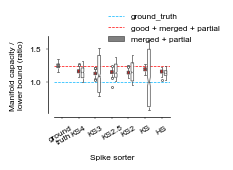

In [14]:
# load dataset --------------------------------
# pipeline parameters
N_BOOT = 200
N_BLOCKS = 1

# get blocks' paths
blocks = np.arange(0, N_BLOCKS, 1)
igeom_path = os.path.splitext(IGEOM_S_Q)[0]
b_paths = get_block_paths(igeom_path, blocks)
display(b_paths)

df_all = []
for p_i in b_paths:
    df_all.append(pd.read_csv(p_i))
df_all = pd.concat(df_all)

# unit-test sample size
g_class = "mixed: good + overmerger + oversplitter"
assert (
    df_all[(df_all["Unit class"] == g_class) & (df_all.Sorter == "KS4")].shape[0]
    == N_BOOT * N_BLOCKS
), "the sample size should match"

# unit test sorters
assert all(
    np.unique(df_all.Sorter)
    == ["HS", "KS", "KS2", "KS2.5", "KS3", "KS4", "ground_truth"]
), "Sorters are missing"

df_all.loc[df_all.Sorter == "ground_truth", "Sorter"] = "ground\ntruth"

# PLOT  --------------------------------

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1))

# set plot parameters
BOXPLOT_PMS = {
    "notch": True,
    "gap": 0.3,
    "width": 0.7,
    "linewidth": 0.5,
    "flierprops": {
        "marker": "o",
        "markerfacecolor": "w",
        "markersize": 1.5,
        "markeredgewidth": 0.5,
    },
}

# highlight lower bound
gt_cap = np.mean(df_all.loc[df_all.Sorter == "ground\ntruth", "Capacity"])
ax.hlines(
    xmin=-0.5,
    xmax=6.5,
    y=1,
    color=[0, 0.7, 1],
    linestyle="--",
)

# highlight ground truth capacity
ax.hlines(
    xmin=-0.5, xmax=len(np.unique(df_all.Sorter)), y=gt_cap, color="r", linestyle="--"
)


# plot
ax = sns.boxplot(
    ax=ax,
    data=df_all,
    x="Sorter",
    y="Capacity",
    hue="Unit class",
    hue_order=[
        "ground_truth",
        "mixed: good + overmerger + oversplitter",
        "mixed: overmerger + oversplitter",
    ],
    palette=["grey", "red", "white"],
    **BOXPLOT_PMS,
)

ax.set_ylabel("Manifold capacity / \nlower bound (ratio)")
ax.set_xlabel("Spike sorter")

# disconnect axis
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)

plt.xticks(rotation=30)

# legend
ax.legend(
    ["ground_truth", "good + merged + partial", "merged + partial"],
    frameon=False,
    loc="upper left",
    bbox_to_anchor=(0.4, 1.4),
)
plt.xticks(rotation=30)

# save
utils.savefig(
    proj_path + "/figures/4_code/fig7E_capacity_by_sorter_and_quality.svg",
)

### Hypothesis testing: good worse than ground truth?

In [28]:
def get_mean_capacity_vs_gt(sorter, df_all):

    # set groups
    g_class = "mixed: good + overmerger + oversplitter"

    # get group data
    g_cap = (
        np.mean(
            df_all[(df_all["Unit class"] == g_class) & (df_all.Sorter == sorter)][
                "Capacity"
            ].values
        )
        - 1
    )
    gt_cap = (
        np.mean(
            df_all[
                (df_all["Unit class"] == "ground_truth")
                & (df_all.Sorter == "ground_truth")
            ]["Capacity"].values
        )
        - 1
    )

    print(
        f"""{sorter} mean capacity: {g_cap} vs full gt: {gt_cap}; changed by {(g_cap - gt_cap) / gt_cap}"""
    )
    return (g_cap - gt_cap) / gt_cap


def get_mean_capacity_good_vs_biased(sorter, df_all):

    # set groups
    g_class = "mixed: good + overmerger + oversplitter"
    b_class = "mixed: overmerger + oversplitter"

    # get group data
    g_cap = (
        np.mean(
            df_all[(df_all["Unit class"] == g_class) & (df_all.Sorter == sorter)][
                "Capacity"
            ].values
        )
        - 1
    )
    b_cap = (
        np.mean(
            df_all[(df_all["Unit class"] == b_class) & (df_all.Sorter == sorter)][
                "Capacity"
            ].values
        )
        - 1
    )

    print(
        f"""{sorter} mean capacity: {g_cap} vs biased: {b_cap}; changed by {(b_cap - g_cap) / g_cap}"""
    )
    return (b_cap - g_cap) / g_cap

In [22]:
df_all.loc[df_all.Sorter == "ground\ntruth", "Sorter"] = "ground_truth"

stats.get_ttest_good_vs_gt(df_all, "KS4")
stats.get_ttest_good_vs_gt(df_all, "KS3")
stats.get_ttest_good_vs_gt(df_all, "KS2.5")
stats.get_ttest_good_vs_gt(df_all, "KS2")
stats.get_ttest_good_vs_gt(df_all, "KS")
stats.get_ttest_good_vs_gt(df_all, "HS")

print("\npercent changes:")
pchange_k4 = get_mean_capacity_vs_gt("KS4", df_all)
pchange_k3 = get_mean_capacity_vs_gt("KS3", df_all)
pchange_k25 = get_mean_capacity_vs_gt("KS2.5", df_all)
pchange_k2 = get_mean_capacity_vs_gt("KS2", df_all)
pchange_ks = get_mean_capacity_vs_gt("KS", df_all)
pchange_hs = get_mean_capacity_vs_gt("HS", df_all)

print(
    "average percent change:",
    np.mean([pchange_k4, pchange_k3, pchange_k25, pchange_k2, pchange_ks, pchange_hs]),
)

KS4: t(199)=-22.58160570770291, p=2.822065372138362e-73
KS3: t(199)=-31.35358032836159, p=1.41368424715049e-109
KS2.5: t(199)=-24.54154700123255, p=1.1562639582374056e-81
KS2: t(199)=-28.307016611841988, p=2.289661060447319e-97
KS: t(199)=-15.598637358358665, p=3.79844011036971e-43
HS: t(199)=-24.84206208588483, p=6.140272966330144e-83

percent changes:
KS4 mean capacity: 0.16757051173535364 vs full gt: 0.25127595712505335; changed by -0.3331215861135562
KS3 mean capacity: 0.13296282878920374 vs full gt: 0.25127595712505335; changed by -0.4708493788642434
KS2.5 mean capacity: 0.15468492963633418 vs full gt: 0.25127595712505335; changed by -0.38440218711672597
KS2 mean capacity: 0.14789110181143794 vs full gt: 0.25127595712505335; changed by -0.4114395045848478
KS mean capacity: 0.19398884785995119 vs full gt: 0.25127595712505335; changed by -0.22798484152859835
HS mean capacity: 0.15963891630069726 vs full gt: 0.25127595712505335; changed by -0.3646868640868445
average percent change: 

### Hypothesis testing: biased worse than good?

* t-test more appropriate as we have sufficient number of samples from bootstrapping.

In [29]:
stats.get_ttest_quality(df_all, "KS4")
stats.get_ttest_quality(df_all, "KS3")
stats.get_ttest_quality(df_all, "KS2.5")
stats.get_ttest_quality(df_all, "KS2")
stats.get_ttest_quality(df_all, "KS")
stats.get_ttest_quality(df_all, "HS")


print("\npercent changes:")
pchange_k4 = get_mean_capacity_good_vs_biased("KS4", df_all)
pchange_k3 = get_mean_capacity_good_vs_biased("KS3", df_all)
pchange_k25 = get_mean_capacity_good_vs_biased("KS2.5", df_all)
pchange_k2 = get_mean_capacity_good_vs_biased("KS2", df_all)
pchange_ks = get_mean_capacity_good_vs_biased("KS", df_all)
pchange_hs = get_mean_capacity_good_vs_biased("HS", df_all)

print(
    "average percent change:",
    np.mean([pchange_k4, pchange_k3, pchange_k25, pchange_k2, pchange_ks, pchange_hs]),
)

KS4: t(399)=4.08130697244248, p=5.086492384027518e-05
KS3: t(399)=0.22624319475647092, p=0.8210895849095406
KS2.5: t(399)=-2.9303889695322143, p=0.0035145932947793237
KS2: t(399)=-1.1132832090455047, p=0.26603410786843495
KS: t(399)=4.191156565698142, p=3.1947062578133584e-05
HS: t(399)=5.125389137324646, p=4.014054730584563e-07

percent changes:
KS4 mean capacity: 0.16757051173535364 vs biased: 0.14327005973742013; changed by -0.14501627849840037
KS3 mean capacity: 0.13296282878920374 vs biased: 0.12839120678214333; changed by -0.03438270717230416
KS2.5 mean capacity: 0.15468492963633418 vs biased: 0.17732324643509134; changed by 0.14635114650134357
KS2 mean capacity: 0.14789110181143794 vs biased: 0.15932218256889108; changed by 0.07729390488974676
KS mean capacity: 0.19398884785995119 vs biased: 0.06455227347913572; changed by -0.6672371933167067
HS mean capacity: 0.15963891630069726 vs biased: 0.14064132866673873; changed by -0.11900348658202184
average percent change: -0.123665769